## Simple random forest classifier as a baseline

Let's train a baseline model using a random forest with a minimal set of features.
- Transaction amount
- Hour of transaction
- Time since last transaction (minutes)
- Transaction category

An ensemble method like a random forest is suitable because we are expecting a nonlinear decision boundary. This would probably yield better results than a logistic regressor, and provide a reasonable level of interpretability. For example, it was found during the EDA stage that for in fraudulent transactions the hour of transaction is more likely to be very early or very late. 

In [ ]:
import sys
import os
os.chdir("..")
# make sure the imports are from the root project directory, run this once only

In [3]:
print(os.getcwd())

/Users/jessewang/Documents/credit-fraud-api


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from typing import List
from src.pipeline import Preprocessor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from src.utils import create_timestamp_columns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Testing the preprocessing pipeline

- Train-test split
- Oversample minority class using SMOTE on the training set
- Apply imputation and standard scaling to numerical features
- Apply imputation and one-hot encoding to categorical features

Below we investigate the effect of applying SMOTE, by training a baseline Logistic Regression classifier
- without oversampling
- with oversampling

In [8]:
filepath = 'data/fraudTrain.csv'
df = pd.read_csv(filepath)

In [9]:
# add the manually engineered timestamp columns
df = create_timestamp_columns(df)

In [10]:
X = df[Preprocessor.all_features]
y = df[Preprocessor.target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# import the Preprocessor object
# this contains logic to apply the aforementioned transformations
preprocessor = Preprocessor(X_train)
X_train_trans = preprocessor.fit_transform()

In [13]:
X_test_trans = preprocessor.transform(X_test)

In [ ]:
# Default hyperparameters: 50 trees, max depth of 5
clf = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1)
clf.fit(X_train_trans, y_train)
y_pred = clf.predict(X_test_trans)

print("\nBefore Applying SMOTE:")
print(classification_report(y_test, y_pred))


Before Applying SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.95      0.48      0.64      1501

    accuracy                           1.00    259335
   macro avg       0.97      0.74      0.82    259335
weighted avg       1.00      1.00      1.00    259335



The model is performing somewhat poorly as the minority class (fraud class) has quite a low recall of 0.46 (number of fraud cases detected over total number of fraud cases), although the precision of the minority class is quite high.

Let's compare this with the same model parameters but with an oversampled minority class:

In [9]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_trans, y_train)

In [10]:
# Check the resampled class distribution
from collections import Counter
Counter(y_train_smote)

Counter({0: 1031335, 1: 1031335})

In [11]:
# Try a random forest classifier with the same hyperparameters, but with the oversampled data
clf_smote = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1)
clf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = clf_smote.predict(X_test_trans)

In [12]:
print("After Applying SMOTE:")
print(classification_report(y_test, y_pred_smote))

After Applying SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    257834
           1       0.15      0.85      0.25      1501

    accuracy                           0.97    259335
   macro avg       0.57      0.91      0.62    259335
weighted avg       0.99      0.97      0.98    259335



We can try to optimise for the F1-Score (the harmonic mean of precision and recall) by choosing a better decision boundary. We can obtain the probability of a fraud prediction and tune the threshold for our classifer such that the F1-Score is maximised, and we can do this for the classifier trained on oversampled data to the classifier trained on the non-oversampled data.

In [14]:
y_probs_smote = clf_smote.predict_proba(X_test_trans)[:, 1]
y_probs = clf.predict_proba(X_test_trans)[:, 1]

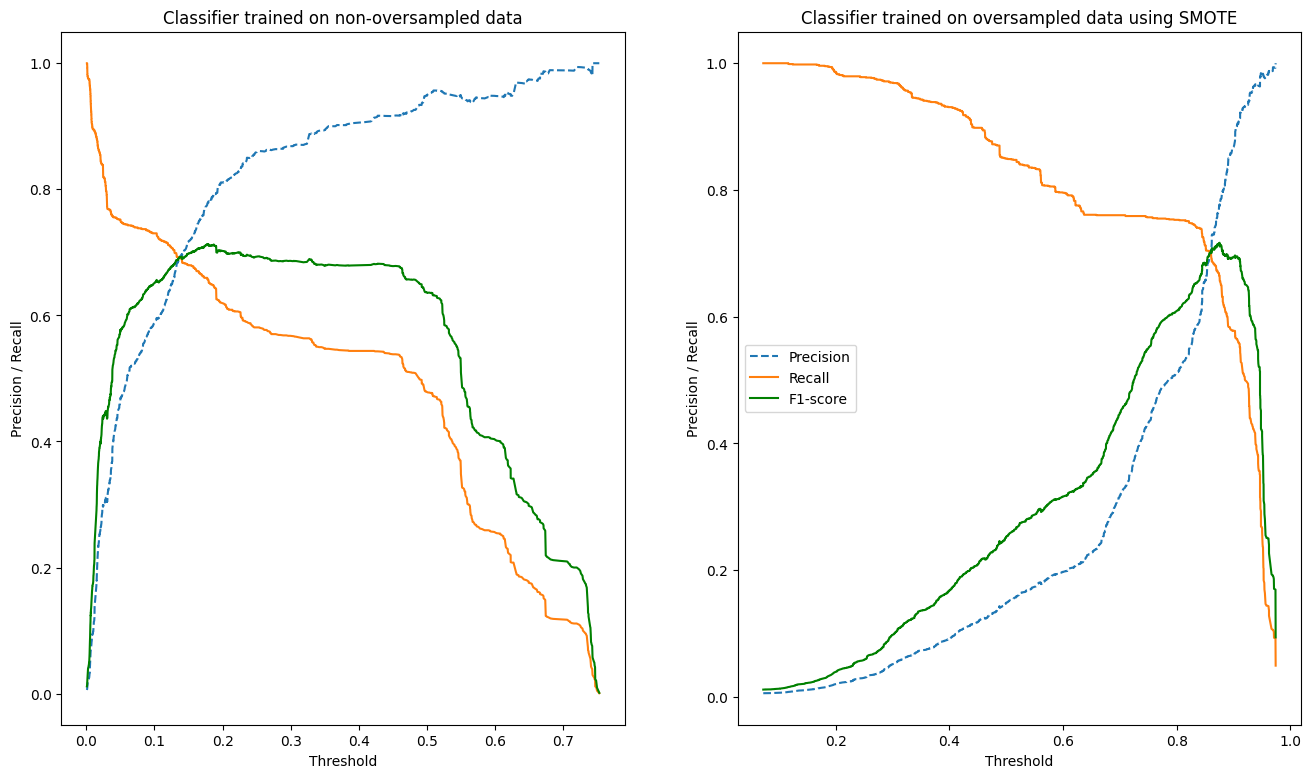

In [15]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
precisions_s, recalls_s, thresholds_s = precision_recall_curve(y_test, y_probs_smote)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
f1_scores_s = 2 * (precisions_s[:-1] * recalls_s[:-1]) / (precisions_s[:-1] + recalls_s[:-1])

fig, axs = plt.subplots(1, 2, figsize=(16, 9))

axs[0].plot(thresholds, precisions[:-1], label="Precision", linestyle="--")
axs[0].plot(thresholds, recalls[:-1], label="Recall")
axs[0].plot(thresholds, f1_scores, label="F1-score", linestyle="-", color="green")
axs[0].set_xlabel("Threshold")
axs[0].set_ylabel("Precision / Recall")
axs[0].set_title("Classifier trained on non-oversampled data")

axs[1].plot(thresholds_s, precisions_s[:-1], label="Precision", linestyle="--")
axs[1].plot(thresholds_s, recalls_s[:-1], label="Recall")
axs[1].plot(thresholds_s, f1_scores_s, label="F1-score", linestyle="-", color="green")
axs[1].set_xlabel("Threshold")
axs[1].set_ylabel("Precision / Recall")
axs[1].set_title("Classifier trained on oversampled data using SMOTE")

plt.legend()


It seems like for both models the effect is good at different decision thresholds; for the unoversampled model the ideal threshold seems to be at a probability of 0.2, whereas for the oversampled model this would be around 0.85.

Let's find the threshold and the classifier that achieves the maximum F1-score, and use this as a baseline for now.

In [17]:
def get_ideal_threshold_and_f1_score(thresholds: List[float], f1_scores: List[float]):
    """
    Return the optimal threshold 
    """
    max_f1 = max(f1_scores)
    max_idx = np.argmax(f1_scores)
    return thresholds[max_idx], max_f1

ideal_threshold_clf, clf_f1 = get_ideal_threshold_and_f1_score(thresholds, f1_scores)
ideal_threshold_clf_smote, clf_smote_f1 = get_ideal_threshold_and_f1_score(thresholds_s, f1_scores_s)

In [25]:
print(f"Without SMOTE: threshold {float(ideal_threshold_clf):.3f}, f1-score {float(clf_f1):.3f}")
print(f"With SMOTE: threshold {float(ideal_threshold_clf_smote):.3f}, f1-score {float(clf_smote_f1):.3f}")

Without SMOTE: threshold 0.177, f1-score 0.713
With SMOTE: threshold 0.875, f1-score 0.717


It seems like the ideal choice in this scenario would be to use the classifier trained on data with oversampled minority classes, at a threshold probability of 0.875.

Another metric we can use to assess the performance of our classifiers is the area under a receiver operating characteristic (ROC) curve, which plots the true positive rate against the false positive rate as the threshold probability is varied.

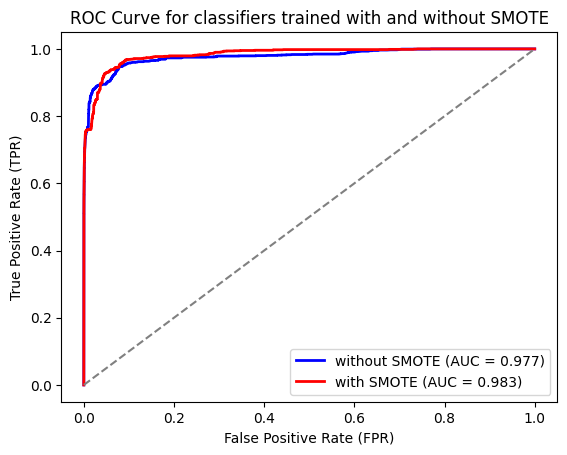

In [27]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_probs_smote)
roc_auc = auc(fpr, tpr)
roc_auc_smote = auc(fpr_smote, tpr_smote)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'without SMOTE (AUC = {roc_auc:.3f})')
plt.plot(fpr_smote, tpr_smote, color='red', lw=2, label=f'with SMOTE (AUC = {roc_auc_smote:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for classifiers trained with and without SMOTE')
plt.legend(loc='lower right')
plt.show()

We can see that the AUC is slightly improved by training the classifier on oversampled data. Thus, we will adopt this approach going forward.

We can now look to tune the hyperparameters of our random forest model. In particular

In [ ]:
# save the trained models
joblib.dump(clf, "models/rf_model.pkl")
joblib.dump(clf_smote, "models/rf_model_smote.pkl")
print("Models saved successfully!")

Models saved successfully!


In [6]:
# load the trained models
clf = joblib.load("models/rf_model.pkl")
clf_smote = joblib.load("models/rf_model_smote.pkl")